# Domácí úloha 3

### Tomáš Novotný

Během řešení úkolu jsem využíval tyto zdroje:
* ML1
* VIZ
* https://scikit-learn.org/stable/modules/clustering.html#k-means
* https://courses.fit.cvut.cz/BI-ZNS/tutorials/media_tutorials_2021_web_cvic07.html#_t%C3%A9ma-2-shlukov%C3%A1-anal%C3%BDza-a-znalostn%C3%AD-syst%C3%A9my

Vložení používaných knihoven

In [1]:
import pandas as pd
import numpy as np
import re
from itertools import product
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Načtení pravidel

V následující buňce je načtení datasetu s pravidly ze souboru.

Formát datasetu je následující:
* **řádky** jsou jednotlivá `pravidla`
* **sloupce** jsou `atributy` v pravidlech, pokud pravidlo atribut neobsahovalo je vyplněno `NaN`, v opačném případě je vyplněná hodnota atributu v daném pravidle

In [2]:
# Název souboru
file_path = 'heart_disease.txt'

# Inicializace prázdných seznamů pro různé části dat
attributes = []
decision_values = []
data = []

# Čtení souboru
with open(file_path, 'r') as file:
    print(file.readline()) # přečtení prvního nepotřebného řádku
    for line in file:
        # Rozdělení řádku podle mezer
        parts = line.split()

        # Čtení atributů
        if 'ATTRIBUTES' in parts:
            num_attributes = int(parts[1])
            for _ in range(num_attributes):
                attributes.append(file.readline().strip())

        # Čtení hodnot pravé strany
        elif 'DECISION_VALUES' in parts:
            num_decision_values = int(parts[1])
            for _ in range(num_decision_values):
                decision_values.append(int(file.readline().strip()))

        # Čtení pravidel
        elif 'RULES' in parts:
            num_rules = int(parts[1]) # počet pravidel
            for _ in range(num_rules):
                rule = file.readline().strip()
                match = re.match(r"\((.*?)\)=>\(disease=(\d+)\[(\d+)\]\)", rule) # formát pravidla přes regulární výraz
                left_side = [ x.replace('(', '').replace(')', '') for x in match.group(1).split('&') ] # pole pravidel na levé straně
                disease_value = int(match.group(2)) # vysvětlovaná proměnná
                rule_number = int(match.group(3)) # nepotřebné číslo u pravidla

                # tvorba datasetu z extrahovaných pravidel
                df_row = {}
                for attribute in left_side:
                    attr_name, attr_value = attribute.split('=') # rozdělení atributu a hodnoty
                    df_row[attr_name.strip()] = float(attr_value) if '.' in attr_value else int(attr_value)
    
                df_row['disease'] = disease_value
                data.append(df_row) # přidání pravidla do datasetu

df = pd.DataFrame(data)
columns = df.columns.tolist()

# Posunutí sloupce 'disease' na konec
columns.remove('disease')
columns.append('disease')
df = df[columns]
# df.describe() # základní statistiky

RULE_SET heart_disease



V následujícím výpisu vidíme, že má `vysvětlovaná proměnná` vyskyty v pravidlech rozložené `rovnoměrně`.

In [3]:
for i in decision_values:
    print(f"Počet řádků s nemocí {i} = {len(df[df['disease'] == i])}")

Počet řádků s nemocí 1 = 43
Počet řádků s nemocí 2 = 56


Atributy `blood_pressure` a `maximum_heart_rate` jsou obsažené jen v pár pravidlech.

Nepředpokládám tedy, že by měli na shluky výrazný vliv a proto je z datasetu `odstraním`.

In [4]:
for col in df.columns:
    print(f"Atribut {col} se nachází v {len(df[col].dropna())} pravidlech")

df.drop(columns=['blood_pressure', 'maximum_heart_rate'], inplace=True) # odstranění sloupců s nevhodnými atributy

Atribut blood_sugar se nachází v 98 pravidlech
Atribut angina se nachází v 95 pravidlech
Atribut thal se nachází v 60 pravidlech
Atribut sex se nachází v 97 pravidlech
Atribut pain_type se nachází v 74 pravidlech
Atribut no._of_vessels se nachází v 50 pravidlech
Atribut electrocardiograph se nachází v 92 pravidlech
Atribut slope_ST se nachází v 62 pravidlech
Atribut blood_pressure se nachází v 7 pravidlech
Atribut oldpeak_equals_ST se nachází v 18 pravidlech
Atribut age se nachází v 58 pravidlech
Atribut maximum_heart_rate se nachází v 2 pravidlech
Atribut disease se nachází v 99 pravidlech


Mezi možné metriky, kterými by se dala měřit podobnost pravidel je **Jaccardova podobnost** ( https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3096052/ ).

Ta počítá **podíl** **společných atributů** a **sjednocení atributů, které pravidla obsahují**.

$
J(A, B) = \frac{|A \cap B|}{|A \cup B|}
$

Pomocí této metriky lze spočítat `Matici podobnosti`.

Řádky i sloupce matice reprezentují pravidla a pro **každou dvojici** je spočtena hodnota `Jaccardovy podobnosti`.


In [5]:
def jaccard(df):
    # Levé strany pravidel
    left_sides = df.columns[:-1]

    # Inicializace matice podobnosti
    similarity_matrix = pd.DataFrame(index=df.index, columns=df.index, dtype=float)

    # Pro každou dvojici spočítá podíl společných atributů a všech atributů
    for i, j in product(df.index, repeat=2):
        set_i = set(df.loc[i, left_sides].dropna().index)
        set_j = set(df.loc[j, left_sides].dropna().index)
        jaccard_similarity = len(set_i.intersection(set_j)) / len(set_i.union(set_j))
        similarity_matrix.loc[i, j] = jaccard_similarity
    
    return similarity_matrix 

Pro shlukování použiji metodu `K-Means`, která **minimalizuje součet kvadratických rozdílů od středového bodu** shluku.

$
U = \sum_{i=1}^{K} \sum_{j=1}^{n_i} ||x_{ij} - s_i||^2
$

Matici podobnosti před shlukováním `normalizujeme`, protože metoda `K-Means` je na velikost dat **citlivá**.

In [6]:
# matice podobnosti
similarity_matrix = jaccard(df)

# standardizace
scaler = StandardScaler()
similarity_matrix_scaled = scaler.fit_transform(similarity_matrix)

print(f"Rozměry matice podobnosti = {similarity_matrix.shape}")

Rozměry matice podobnosti = (99, 99)


V následující buňce vysledujeme, který počet shluků je **nejvhodnější** podle `Elbow metody`.

V místě na grafu, kde se směr vývoje účelové funkce *láme* by se měl nacházet **vhodný počet shluků**.

**Experimentálně** jsem vybral počet shluků **6**.

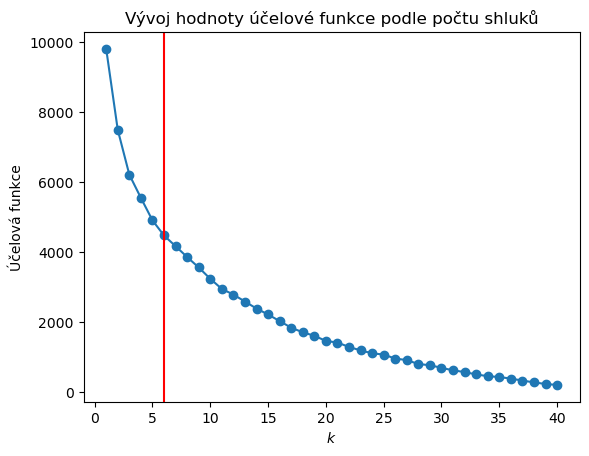

In [7]:
clusters = 40 # maximální počet shluků
best_clusters = 6 # eperimentálně vybraný počet shluků

ix = np.zeros(clusters)
iy = np.zeros(clusters)

# shlukování pomocí K-Means
for i in range(ix.shape[0]):
    kmeans = KMeans(n_clusters=i+1, random_state = 1)
    kmeans.fit(similarity_matrix_scaled)
    iy[i] = kmeans.inertia_
    ix[i] = i+1

# Graf vývoje účelové funkce podle počtu shluků
plt.title("Vývoj hodnoty účelové funkce podle počtu shluků")
plt.xlabel('$k$')
plt.ylabel('Účelová funkce')
plt.plot(ix, iy, 'o-')
plt.axvline(best_clusters, color='r')
plt.show()

V následující buňce rozděluji pravidla do **6** **shluků** metodou `K-Means` a přidávám sloupec `cluster` do datasetu obsahující **číslo shluku** daného pravidla.

In [8]:
df_clusters = df.copy()
kmeans = KMeans(n_clusters=best_clusters, random_state = 42)
kmeans.fit(similarity_matrix_scaled)
df_clusters["cluster"] = kmeans.labels_

V následujícím výstupu jsou ke každému **shluku pravidel** a **hodnotě vysvětlované proměnné** vypsány následující hodnoty:
* Počet pravidel ve shluku
* Kolik atributů mají společných
* Společné atributy

In [9]:
for cluster, disease in product(range(0, best_clusters), decision_values):
    cleaned = df_clusters[(df_clusters["cluster"] == cluster) & (df_clusters['disease'] == disease)].dropna(axis=1)
    cols = list(cleaned.columns)[:-2]
    print(f"Shluk = {cluster}, Nemoc = {disease}: {cleaned.shape[0]} záznamů, {len(cols)} atributů")
    print(cols, end="\n\n")

Shluk = 0, Nemoc = 1: 13 záznamů, 5 atributů
['blood_sugar', 'angina', 'thal', 'sex', 'electrocardiograph']

Shluk = 0, Nemoc = 2: 14 záznamů, 5 atributů
['blood_sugar', 'angina', 'sex', 'pain_type', 'electrocardiograph']

Shluk = 1, Nemoc = 1: 5 záznamů, 4 atributů
['blood_sugar', 'sex', 'pain_type', 'electrocardiograph']

Shluk = 1, Nemoc = 2: 7 záznamů, 6 atributů
['blood_sugar', 'angina', 'sex', 'pain_type', 'electrocardiograph', 'age']

Shluk = 2, Nemoc = 1: 9 záznamů, 4 atributů
['blood_sugar', 'sex', 'no._of_vessels', 'electrocardiograph']

Shluk = 2, Nemoc = 2: 4 záznamů, 4 atributů
['blood_sugar', 'angina', 'sex', 'no._of_vessels']

Shluk = 3, Nemoc = 1: 3 záznamů, 3 atributů
['blood_sugar', 'electrocardiograph', 'slope_ST']

Shluk = 3, Nemoc = 2: 17 záznamů, 4 atributů
['blood_sugar', 'angina', 'sex', 'slope_ST']

Shluk = 4, Nemoc = 1: 9 záznamů, 7 atributů
['blood_sugar', 'angina', 'sex', 'pain_type', 'no._of_vessels', 'electrocardiograph', 'age']

Shluk = 4, Nemoc = 2: 12 z

In [10]:
# funkce na výpis grafu, zobrazujícího četnost atributů ve shlucích
def plot_result(i):
    cleaned = df_clusters[df_clusters["cluster"] == i].dropna(axis=1)
    non_null = list(cleaned.columns)[:-2]

    cols = list(df_clusters.columns)[:-2]
    portion = [ df_clusters[df_clusters["cluster"] == i][col].count() for col in cols ]
    labels = [ x for x in cols ]
    colors = [ "red" if x in non_null else "green" for x in cols ]

    # nastavení figure
    fig = plt.figure(figsize=(14,2), facecolor='white', constrained_layout=True)
    fig.suptitle(f"Počet pravidel ve shluku {i} obsahující dané atributy", fontsize=18)
    ax = fig.add_subplot()
    # graf
    react = ax.bar(labels, portion, color=colors, width=0.8)
    # popisky grafu
    ax.bar_label(react)
    ax.set_xlabel("Atribut")
    ax.set_ylabel("Četnost")
    ax.spines['top'].set_visible(False) 
    ax.spines['right'].set_visible(False)
    plt.show()

Na následující vizualizaci si můžeme prohlédnout `zastoupení atributů ve shlucích`.

`Červeně` jsou zvýraznění atributy, které se nachází ve **všech** pravidlech daného shluku.

Můžeme si všimnout, že shluky mají opravdu `rozdílně zastoupené atributy`.

**Kromě posledního** shluku mají shluky `relativně unikátní profil`.

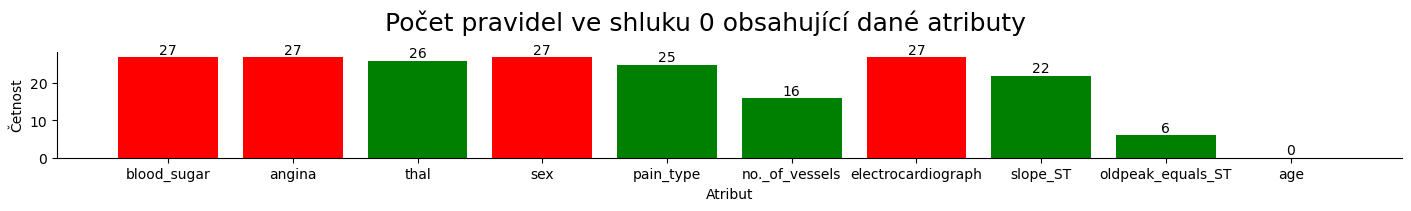

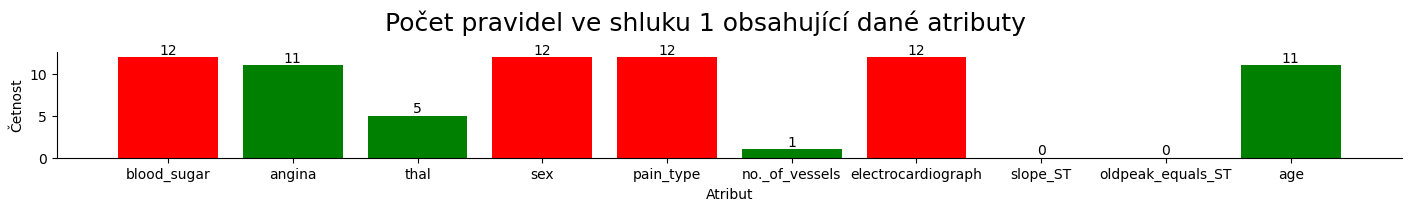

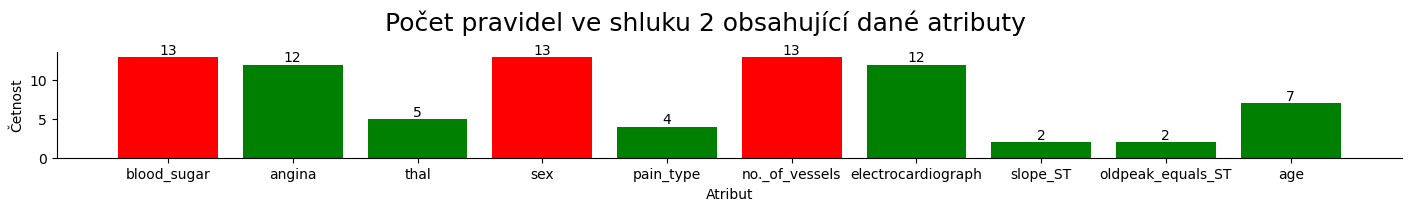

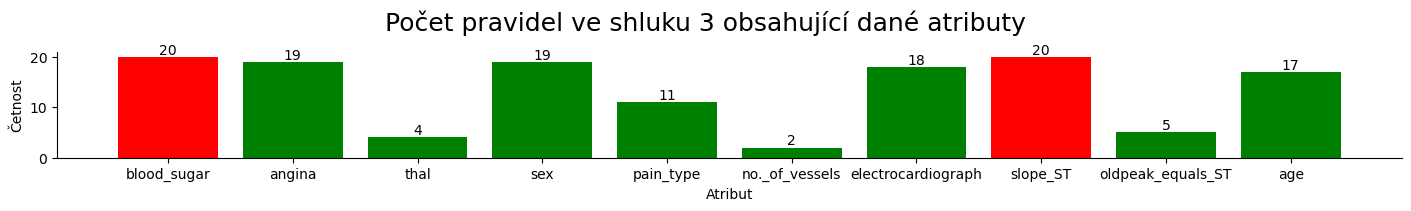

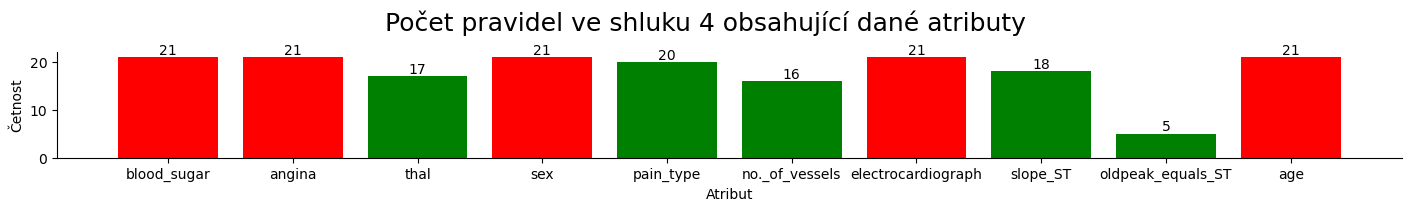

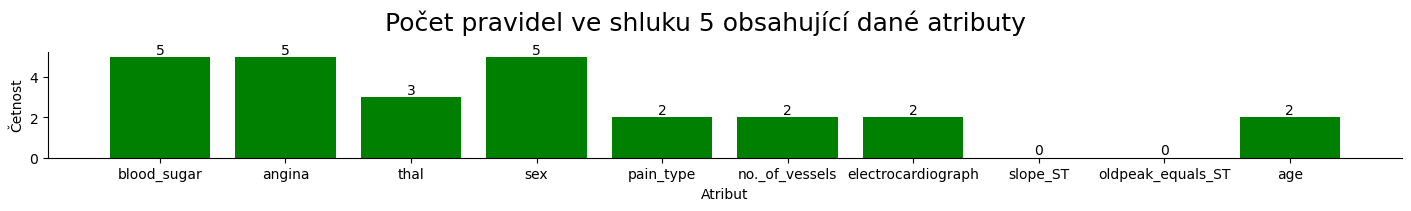

In [11]:
for i in range(best_clusters):
    plot_result(i)

Na následujícím výstupu je `profil shluků` popsaný `pravidly` **pro každou hodnotu vysvětlované proměnné**.

Před každým pravidlem je v hranatých závorkách `počet pravidel`, ze kterých profilové pravidlo `vychází`.

Vybraly se `společné atributy` pro tyto pravidla a hodnota atributu se zvolila jako `medián`.

*Poznámky: Ve všech pravidlech je blood_sugar = 0.0, Pátý shluk je nereprezentativní.*

In [12]:
for cluster in range(0, best_clusters):
    print(f"SHLUK: {cluster}")
    for disease in decision_values:
        cleaned = df_clusters[(df_clusters["cluster"] == cluster) & (df_clusters['disease'] == disease)].dropna(axis=1)
        cols = list(cleaned.columns)[:-2]
        print(f"[{cleaned.shape[0]}] ", end="")
        for col in cols:
            print(f"{col} = {cleaned[col].median()}", end=(' && ' if col != cols[len(cols)-1] else '   ==> '))
        print(f"disease = {disease}", end="\n\n")

SHLUK: 0
[13] blood_sugar = 0.0 && angina = 0.0 && thal = 3.0 && sex = 1.0 && electrocardiograph = 2.0   ==> disease = 1

[14] blood_sugar = 0.0 && angina = 1.0 && sex = 1.0 && pain_type = 4.0 && electrocardiograph = 1.0   ==> disease = 2

SHLUK: 1
[5] blood_sugar = 0.0 && sex = 1.0 && pain_type = 3.0 && electrocardiograph = 0.0   ==> disease = 1

[7] blood_sugar = 0.0 && angina = 0.0 && sex = 1.0 && pain_type = 4.0 && electrocardiograph = 2.0 && age = 58.0   ==> disease = 2

SHLUK: 2
[9] blood_sugar = 0.0 && sex = 1.0 && no._of_vessels = 0.0 && electrocardiograph = 2.0   ==> disease = 1

[4] blood_sugar = 0.0 && angina = 0.0 && sex = 1.0 && no._of_vessels = 0.0   ==> disease = 2

SHLUK: 3
[3] blood_sugar = 0.0 && electrocardiograph = 0.0 && slope_ST = 1.0   ==> disease = 1

[17] blood_sugar = 0.0 && angina = 0.0 && sex = 1.0 && slope_ST = 2.0   ==> disease = 2

SHLUK: 4
[9] blood_sugar = 0.0 && angina = 0.0 && sex = 1.0 && pain_type = 3.0 && no._of_vessels = 0.0 && electrocardiograph 

V poslední řadě `uložíme` pravidla rozdělená do shluků `do souboru`.

In [13]:
df_clusters.to_csv("rules_in_clusters.csv")

*Poznámka k řešení:*
S řešením by se dalo dále experimentovat tak, že by se do profilových pravidel přidaly i atributy, které nejsou ve shlucích zastoupeny ve všech pravidlech, ale na grafech je vidět, že kromě pár pravidel ve všech jsou.